In [1]:
import os
import sys
import copy 

In [2]:
root = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
sys.path.append(root)

## View the test molecules

In [3]:
import pandas as pd
import numpy as np 
from rdkit.Chem import PandasTools
import rdkit
from rdkit import Chem #This gives us most of RDkits's functionality
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
IPythonConsole.ipython_useSVG=True  #SVG's tend to look nicer than the png counterparts
print(rdkit.__version__)

# Mute all errors except critical
Chem.WrapLogs()
lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)

2021.09.4


In [4]:
test_smi = pd.read_csv('./tauto.smi', sep=' ', header=None, names=['SMILES','Name'])

In [5]:
test_smi.sample(2)

SMILES         Name
1               C1(=CC(=NC(=C1)Cl)Cl)O  Cl-pyridone
4  N=C(C1=C(OCC2=C(F)C=CC=C2)C=CC=C1)O          boo

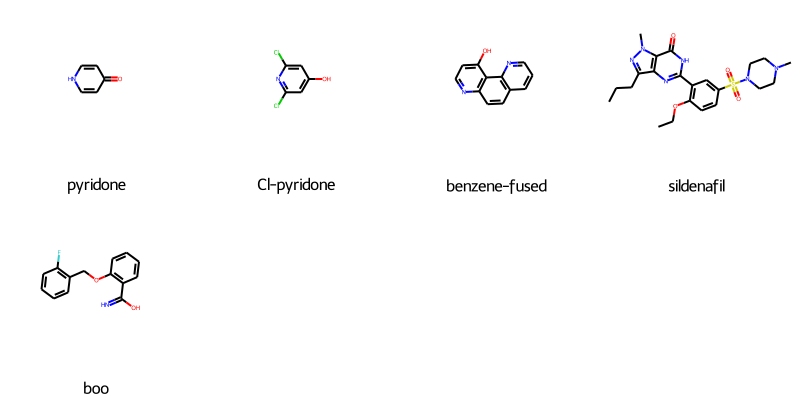

In [6]:
PandasTools.AddMoleculeColumnToFrame(test_smi, smilesCol='SMILES')
PandasTools.FrameToGridImage(test_smi, legendsCol='Name', molsPerRow=4)

# Generate low-energy 3D structures with Auto3D

In [7]:
#Always ensure that you have the latest version
import Auto3D
from Auto3D.auto3D import options, main
print(Auto3D.__version__)

2.0


In [8]:
options

<function Auto3D.auto3D.options(path, k=False, window=False, verbose=False, job_name='', enumerate_tautomer=False, tauto_engine='rdkit', pKaNorm=True, isomer_engine='rdkit', enumerate_isomer=True, mode_oe='classic', mpi_np=4, max_confs=None, use_gpu=True, gpu_idx=0, capacity=42, optimizing_engine='AIMNET', patience=1000, opt_steps=5000, convergence_threshold=0.003, threshold=0.3, memory=None, batchsize_atoms=1024)>

In [9]:
out = '/lrlhps/users/l017301/SHARE/PROJECTS/SOFTWARE/Auto3D/Jan14/20230116-172252-638797_tauto/tauto_out.sdf'

In [10]:
out_folder = os.path.dirname(out)

## Read the SDF files 

In [22]:
import mols2grid
from rdkit import Chem
from rdkit.Chem import AllChem

In [23]:
sdf_df = PandasTools.LoadSDF(out)

ID                E_tot                   fmax  \
0      Cl-pyridone@taut1  -1242.4485217285633  0.0028711010236293077   
1      Cl-pyridone@taut2  -1242.4576208991289  0.0029037443455308676   
2    benzene-fused@taut1   -646.5230541429044  0.0028541951905936003   
3    benzene-fused@taut2   -646.5449096909285    0.00297327502630651   
4    benzene-fused@taut3   -646.5199764570714  0.0022692130878567696   
..                   ...                  ...                    ...   
228     sildenafil@taut9  -1883.1668644994259  0.0027246379759162664   
229     sildenafil@taut9   -1883.166294679022  0.0028603156097233295   
230     sildenafil@taut9  -1883.1660918444156   0.002793555613607168   
231     sildenafil@taut9  -1883.1657381802559   0.002911796560510993   
232     sildenafil@taut9  -1883.1640510409832  0.0027946573682129383   

    Converged     E_rel(kcal/mol)  \
0        True                 0.0   
1        True                 0.0   
2        True                 0.0   
3        True                 0.0   
4        True                 0.0   
..        ...                 ...   
228      True  2.6457204767372136   
229      True  3.0032881786646404   
230      True   3.130568815727958   
231      True  3.3524964267405757   
232      True   4.411192304313834   

                                                 ROMol  
0    <img data-content="rdkit/molecule" src="data:i...  
1    <img data-content="rdkit/molecule" src="data:i...  
2    <img data-content="rdkit/molecule" src="data:i...  
3    <img data-content="rdkit/molecule" src="data:i...  
4    <img data-content="rdkit/molecule" src="data:i...  
..                                                 ...  
228  <img data-content="rdkit/molecule" src="data:i...  
229  <img data-content="rdkit/molecule" src="data:i...  
230  <img data-content="rdkit/molecule" src="data:i...  
231  <img data-content="rdkit/molecule" src="data:i...  
232  <img data-content="rdkit/molecule" src="data:i...  

[233 rows x 6 columns]
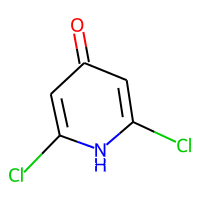
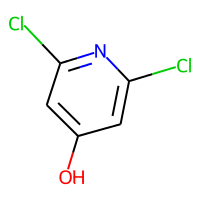
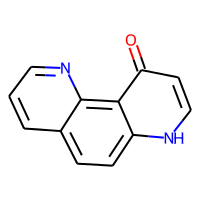
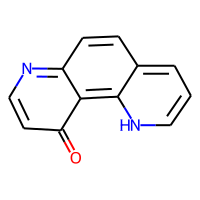
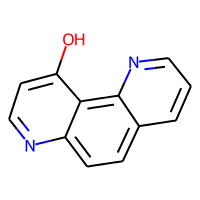
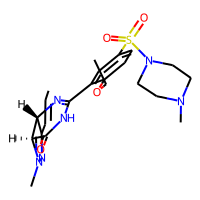
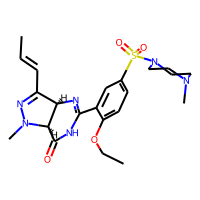
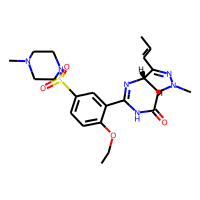
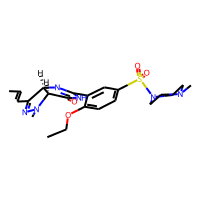
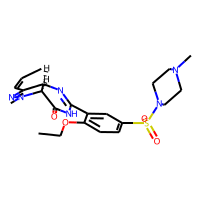

In [24]:
sdf_df

In [25]:
sdf_df = sdf_df.sort_values('E_tot', ascending=False)
sdf_df = sdf_df.drop_duplicates(subset=['ID'])
sdf_df['parent_id'] = [x.split('@')[0] for x in sdf_df['ID']]
sdf_df['tauto_id'] = [x.split('@')[1] for x in sdf_df['ID']]
sdf_df['SMILES'] = [Chem.MolToSmiles(x) for x in sdf_df['ROMol']]
sdf_df['E_tot'] = sdf_df['E_tot'].astype(float)

In [26]:
sdf_df.columns

Index(['ID', 'E_tot', 'fmax', 'Converged', 'E_rel(kcal/mol)', 'ROMol',
       'parent_id', 'tauto_id', 'SMILES'],
      dtype='object')

In [27]:
sdf_format = sdf_df[['parent_id','tauto_id', 'ID', 'SMILES', 'E_tot', 'fmax', 'Converged', 'E_rel(kcal/mol)']]

In [30]:
# convert Hatrees to kcal/mol http://wild.life.nctu.edu.tw/class/common/energy-unit-conv-table.html
E_rel = []
for parent_id in set(list(sdf_format['parent_id'])):
  sdf_format_per_parent = sdf_format.loc[ sdf_format['parent_id'] == parent_id ]
  sdf_format_per_parent.loc[sdf_format_per_parent.index, 'E_rel_tauto(kcal/mol)'] = (sdf_format_per_parent['E_tot'] - min(sdf_format_per_parent['E_tot'])) * 627.5095
  E_rel.append(sdf_format_per_parent)
sdf_format = pd.concat(E_rel)

/node/scratch/106404095.1.all.normal.q/ipykernel_28232/475714180.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_format_per_parent.loc[sdf_format_per_parent.index, 'E_rel_tauto(kcal/mol)'] = (sdf_format_per_parent['E_tot'] - min(sdf_format_per_parent['E_tot'])) * 627.5095


In [31]:
sdf_format

parent_id tauto_id                   ID  \
167     sildenafil   taut26    sildenafil@taut26   
174     sildenafil   taut27    sildenafil@taut27   
183     sildenafil   taut28    sildenafil@taut28   
155     sildenafil   taut24    sildenafil@taut24   
119     sildenafil   taut20    sildenafil@taut20   
210     sildenafil    taut5     sildenafil@taut5   
91      sildenafil   taut17    sildenafil@taut17   
151     sildenafil   taut23    sildenafil@taut23   
96      sildenafil   taut18    sildenafil@taut18   
81      sildenafil   taut15    sildenafil@taut15   
143     sildenafil   taut22    sildenafil@taut22   
101     sildenafil   taut19    sildenafil@taut19   
227     sildenafil    taut9     sildenafil@taut9   
160     sildenafil   taut25    sildenafil@taut25   
187     sildenafil    taut3     sildenafil@taut3   
111     sildenafil    taut2     sildenafil@taut2   
222     sildenafil    taut8     sildenafil@taut8   
213     sildenafil    taut6     sildenafil@taut6   
88      sildenafil   taut16    sildenafil@taut16   
72      sildenafil   taut14    sildenafil@taut14   
55      sildenafil   taut13    sildenafil@taut13   
193     sildenafil    taut4     sildenafil@taut4   
217     sildenafil    taut7     sildenafil@taut7   
21      sildenafil   taut10    sildenafil@taut10   
17      sildenafil    taut1     sildenafil@taut1   
29      sildenafil   taut11    sildenafil@taut11   
129     sildenafil   taut21    sildenafil@taut21   
37      sildenafil   taut12    sildenafil@taut12   
9              boo    taut2            boo@taut2   
5              boo    taut1            boo@taut1   
15        pyridone    taut1       pyridone@taut1   
16        pyridone    taut2       pyridone@taut2   
3    benzene-fused    taut2  benzene-fused@taut2   
2    benzene-fused    taut1  benzene-fused@taut1   
4    benzene-fused    taut3  benzene-fused@taut3   
1      Cl-pyridone    taut2    Cl-pyridone@taut2   
0      Cl-pyridone    taut1    Cl-pyridone@taut1   

                                                SMILES        E_tot  \
167  CCCc1nn(C)c2c(=O)[nH]c(-c3cc(S(=O)(=O)N4CCN(C)... -1883.237851   
174  CCCc1nn(C)c2c(=O)nc(-c3cc(S(=O)(=O)N4CCN(C)CC4... -1883.217860   
183  CCCc1nn(C)c2c(O)nc(-c3cc(S(=O)(=O)N4CCN(C)CC4)... -1883.211783   
155  CC/C=C1/NN(C)c2c1nc(-c1cc(S(=O)(=O)N3CCN(C)CC3... -1883.198682   
119  C/C=C/c1nn(C)c2c1N[C@@H](c1cc(S(=O)(=O)N3CCN(C... -1883.195765   
210  C/C=C/C1=C2NC(c3cc(S(=O)(=O)N4CCN(C)CC4)ccc3OC... -1883.185570   
91   C/C=C/c1nn(C)c2c1N=C(c1cc(S(=O)(=O)N3CCN(C)CC3... -1883.185264   
151  CC/C=C1/NN(C)c2c1[nH]c(-c1cc(S(=O)(=O)N3CCN(C)... -1883.183689   
96   C/C=C/c1nn(C)c2c1NC(c1cc(S(=O)(=O)N3CCN(C)CC3)... -1883.178366   
81   C/C=C/[C@@H]1NN(C)c2c1nc(-c1cc(S(=O)(=O)N3CCN(... -1883.176364   
143  CC/C=C1/NN(C)c2c(O)nc(-c3cc(S(=O)(=O)N4CCN(C)C... -1883.173366   
101  C/C=C/c1nn(C)c2c1N[C@@H](c1cc(S(=O)(=O)N3CCN(C... -1883.172031   
227  C/C=C/C1=NN(C)[C@@H]2C(=O)NC(c3cc(S(=O)(=O)N4C... -1883.171081   
160  CCCC1=NN(C)[C@@H]2C(=O)N=C(c3cc(S(=O)(=O)N4CCN... -1883.169082   
187  C/C=C/C1=C2N=C(c3cc(S(=O)(=O)N4CCN(C)CC4)ccc3O... -1883.166379   
111  C/C=C/C1=C2N=C(c3cc(S(=O)(=O)N4CCN(C)CC4)ccc3O... -1883.164880   
222  C/C=C/C1=NN(C)[C@@H]2C(=O)N=C(c3cc(S(=O)(=O)N4... -1883.164851   
213  C/C=C\C1=NN(C)C2=C(O)N=C(c3cc(S(=O)(=O)N4CCN(C... -1883.164151   
88   C/C=C/c1nn(C)c2c1=N[C@@H](c1cc(S(=O)(=O)N3CCN(... -1883.159181   
72   C/C=C\[C@@H]1NN(C)c2c1[nH]c(-c1cc(S(=O)(=O)N3C... -1883.159030   
55   C/C=C\[C@@H]1NN(C)c2c(O)nc(-c3cc(S(=O)(=O)N4CC... -1883.148282   
193  C/C=C/C1=C2NC(c3cc(S(=O)(=O)N4CCN(C)CC4)ccc3OC... -1883.144197   
217  C/C=C/C1=NN(C)C2=C(O)NC(c3cc(S(=O)(=O)N4CCN(C)... -1883.144103   
21   C/C=C/C1=NN(C)[C@@H]2C(O)=NC(c3cc(S(=O)(=O)N4C... -1883.142340   
17   C/C=C/C1=C2N=C(c3cc(S(=O)(=O)N4CCN(C)CC4)ccc3O... -1883.142246   
29   C/C=C/C1=NN(C)[C@@H]2C1=NC(c1cc(S(=O)(=O)N3CCN... -1883.141071   
129  CC/C=C1/NN(C)[C@@H]2C(=O)N=C(c3cc(S(=O)(=O)N4C... -1883.140111   
37   C/C=C\[C@@H]1NN(C)[C@H]2C(=O)N=C(c3cc(S

In [38]:
mols2grid.display(sdf_format, 
                  # set what's displayed on the grid
                  subset=["parent_id", "img", "tauto_id","E_rel_tauto(kcal/mol)"],
                  # set what's displayed on the hover tooltip
                  tooltip=["parent_id", "E_tot", "fmax", "E_rel_tauto(kcal/mol)"],
                  transform={"E_rel_tauto(kcal/mol)": lambda x: r"del_E_tauto: {0:0.3f} kcal/mol".format(x)},
                  size=(250,250))

## Saving and viewing the SD files 

Here I am looking at the 3D conformers of the original and tautomers 

In [39]:
inf = open(os.path.join(out_folder, 'job1','smi_taut_3d.sdf'),'rb')
with Chem.ForwardSDMolSupplier(inf) as fsuppl:
    ms = [x for x in fsuppl if x is not None]

In [40]:
## Combine all the conformers for a given molecule in 1 molecule object 
mol_dict = []
get_og_name = [x.GetProp('ID').split('@')[0] for x in ms]
for index, row in test_smi.iterrows():
  item_index = []
  for entry_index, og_name in enumerate(get_og_name):
    if str(row['Name']) == og_name:
      item_index.append(entry_index)
  list_sdf = [ms[i] for i in item_index]
  sdf_dict = {}
  sdf_dict['parent'] = row['Name']
  sdf_dict['conformers'] = list_sdf 
  mol_dict.append(sdf_dict)

In [41]:
def to_sdf(mol_dict):
  parent_id = mol_dict['parent']
  w = Chem.SDWriter(f'{out_folder}/conformers_{parent_id}.sdf')
  sdfs = mol_dict['conformers']
  for entries in sdfs:
    w.write(entries)
  w.close()

def append_conformers_to_mol(mol_dict):
  parent_id = mol_dict['parent']
  sdfs = mol_dict['conformers']
  ref = copy.deepcopy(sdfs[0])
  for mol in sdfs:
    conf_mol = mol.GetConformer()
    mol_props = mol.GetPropsAsDict()
    for key, value in mol_props.items():
      conf_mol.SetProp(str(key), str(value))
    ref.AddConformer(conf_mol, assignId=True)
  
  for name in ref.GetPropNames():
    ref.ClearProp(name)
  
  ref.SetProp('_Name',str(parent_id))
  Chem.rdMolAlign.AlignMolConformers(ref)
  return ref 

In [42]:
for mol_list in mol_dict:
  print(mol_list['parent'], len(mol_list['conformers']))

pyridone 2
Cl-pyridone 2
benzene-fused 3
sildenafil 216
boo 10


In [43]:
mol_dict[1]

{'parent': 'Cl-pyridone',
 'conformers': [<rdkit.Chem.rdchem.Mol at 0x2b29365373a0>,
  <rdkit.Chem.rdchem.Mol at 0x2b2936537030>]}

In [44]:
to_sdf(mol_dict[1])

In [45]:
ref = append_conformers_to_mol(mol_dict[-1])

In [46]:
# http://rdkit.blogspot.com/2016/07/using-ipywidgets-and-py3dmol-to-browse.html
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
from ipywidgets import interact, interactive, fixed

In [47]:
ref.GetNumConformers()

11

What I want to do is generate a set of conformers for a molecule and scroll through them interactively. Here's some code for doing that:

In [48]:
# https://birdlet.github.io/2019/10/02/py3dmol_example/
# http://rdkit.blogspot.com/2016/07/using-ipywidgets-and-py3dmol-to-browse.html

import py3Dmol

def MolTo3DView(mol, confId, size=(400, 400), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol, confId=confId)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'sdf')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

In [49]:
ref.GetProp('_Name')

'boo'

In [50]:
for conf in ref.GetConformers():
    print(conf.GetId())

0
1
2
3
4
5
6
7
8
9
10


In [51]:
from ipywidgets import interact,fixed,IntSlider
import ipywidgets

from rdkit import Chem
from rdkit.Chem import AllChem

def conf_viewer(mol, confId=-1):
    return MolTo3DView(mol, confId).show()

interact(conf_viewer, mol=fixed(ref), confId=ipywidgets.IntSlider(min=0,max=ref.GetNumConformers()-1, step=1))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

interactive(children=(IntSlider(value=0, description='confId', max=10), Output()), _dom_classes=('widget-inter…

<function __main__.conf_viewer(mol, confId=-1)>

In [52]:
sdf_mol_info = sdf_format.loc[ sdf_format['parent_id'] == ref.GetProp('_Name')]

In [54]:
mols2grid.display(sdf_mol_info, 
                  # set what's displayed on the grid
                  subset=["parent_id", "img", "tauto_id","E_rel_tauto(kcal/mol)"],
                  # set what's displayed on the hover tooltip
                  tooltip=["parent_id", "E_tot", "fmax", "E_rel_tauto(kcal/mol)"],
                  transform={"E_rel_tauto(kcal/mol)": lambda x: f'del_E_tauto: {round(x, 3)} kcal/mol'},
                  size=(250,250))